In [1]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD,Adagrad,Adam, Nadam
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt     
from keras.preprocessing import image    
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import BatchNormalization,Dropout, Flatten, Dense, Input
from keras.models import Sequential,Model,model_from_json
from sklearn.metrics import log_loss
from keras import optimizers
import math
import pickle
import os
import pandas as pd
import datetime
from keras.callbacks import EarlyStopping, Callback,ModelCheckpoint
from sklearn.model_selection import KFold 
from keras.regularizers import l1,l2,l1_l2
from keras.layers.noise import AlphaDropout

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure(figsize=(3,2))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=False)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend(['train', 'test'], loc='upper left')
        plt.show();

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    subfile = os.path.join('subm', 'submission_' + suffix + '.csv')
    result.to_csv(subfile, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    img = cv2.imread(path)
    img_rows, img_cols=224,224
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

def load_train():
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_imc(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
    return driver_file,driver_id

def split_list(l,size):
    return [l[i*len(l) // size: (i+1)*len(l) // size] for i in range(size)]

def load_test_parts(part,splits):
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    test_chunks=split_list(data,splits)
    
    for p in test_chunks[part]:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))

    return driver_file,driver_id

def append_chunk(main, part):
    for p in part:
        main.append(p)
        
    return main

def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.uint8)
    target = np.array(target,dtype=np.uint8)
    return data, target

def get_val_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.float32)
    target = np.array(target,dtype=np.uint8)
    index = np.array(index)
    return data, target, index

def data_split(data,target,test_size,driver_id,driver_list):
        random.shuffle(driver_list)
        test_split=test_size*len(driver_list)
        test_split=int(round(test_split))
       
        train_list=driver_list[test_split:]
        test_list=driver_list[:test_split]
        
        X_train,y_train = get_selected_drivers(data,target,driver_id,train_list)
        X_test,y_test = get_selected_drivers(data,target,driver_id,test_list)

        return X_train, X_test, y_train, y_test, test_list
    
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    
    return a.tolist()

img_rows=224
img_cols=224
img_channel=3  

batch_size=32
nfolds=3
epochs=20
model_list=[
    #'ResNet50'
    #,
     'VGG19'
           ]

Using TensorFlow backend.


Model:  VGG19
Restore train from cache
Start KFold number 1 from 3
Split train:  15098 15098
Split valid:  7326 7326
Train drivers:  ['p002', 'p015', 'p016', 'p021', 'p022', 'p035', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p014', 'p024', 'p026', 'p039', 'p041', 'p056', 'p061', 'p072']
Score log_loss:  0.537211988005
Start KFold number 2 from 3
Split train:  14417 14417
Split valid:  8007 8007
Train drivers:  ['p002', 'p012', 'p014', 'p021', 'p024', 'p026', 'p035', 'p039', 'p041', 'p050', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p015', 'p016', 'p022', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052']
Score log_loss:  0.458483997796
Start KFold number 3 from 3
Split train:  15333 15333
Split valid:  7091 7091
Train drivers:  ['p012', 'p014', 'p015', 'p016', 'p022', 'p024', 'p026', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p072']
Test drivers:  ['p00

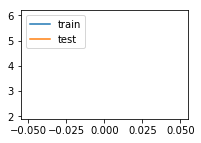

Epoch 00001: val_loss improved from inf to 6.01508, saving model to cache\weights_kfold_augmented_VGG19_3.h5


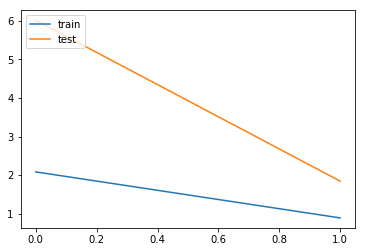

Epoch 00002: val_loss improved from 6.01508 to 1.84390, saving model to cache\weights_kfold_augmented_VGG19_3.h5


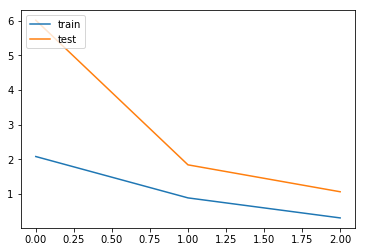

Epoch 00003: val_loss improved from 1.84390 to 1.06753, saving model to cache\weights_kfold_augmented_VGG19_3.h5


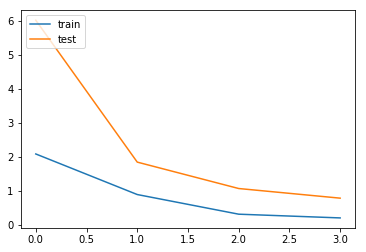

Epoch 00004: val_loss improved from 1.06753 to 0.78413, saving model to cache\weights_kfold_augmented_VGG19_3.h5


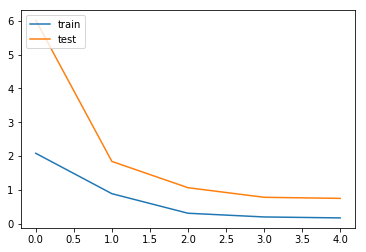

Epoch 00005: val_loss improved from 0.78413 to 0.75212, saving model to cache\weights_kfold_augmented_VGG19_3.h5


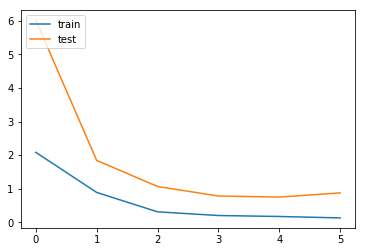

Epoch 00006: val_loss did not improve


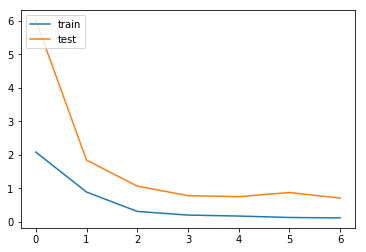

Epoch 00007: val_loss improved from 0.75212 to 0.70904, saving model to cache\weights_kfold_augmented_VGG19_3.h5


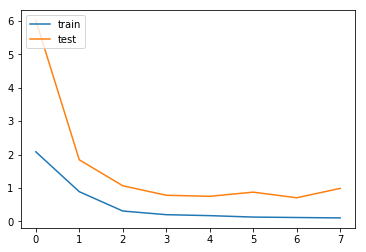

Epoch 00008: val_loss did not improve


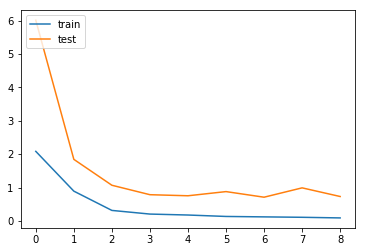

Epoch 00009: val_loss did not improve


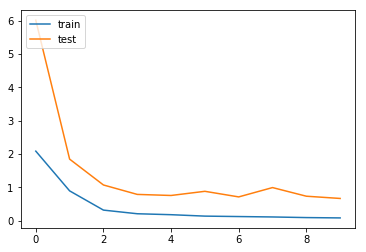

Epoch 00010: val_loss improved from 0.70904 to 0.66259, saving model to cache\weights_kfold_augmented_VGG19_3.h5


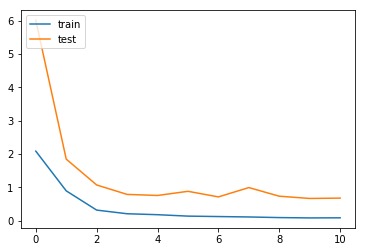

Epoch 00011: val_loss did not improve


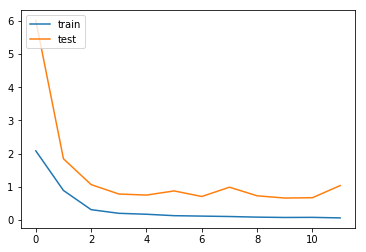

Epoch 00012: val_loss did not improve


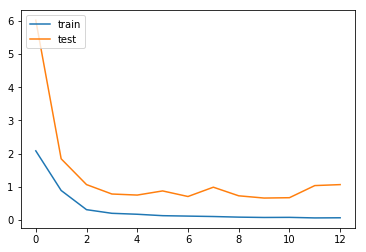

Epoch 00013: val_loss did not improve


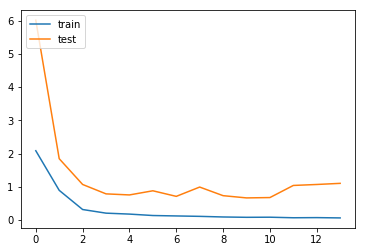

Epoch 00014: val_loss did not improve


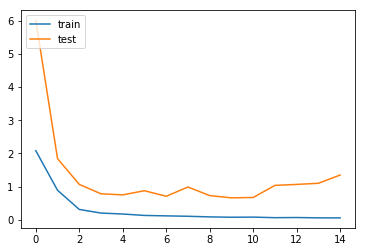

Epoch 00015: val_loss did not improve


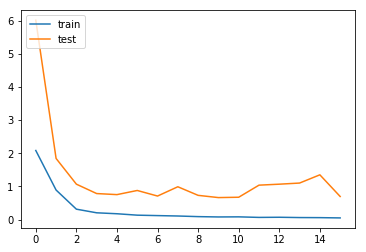

Epoch 00016: val_loss did not improve
Score log_loss:  0.662589872891
(validation score only) Final log_loss: 0.5487478230085572, nfolds: 3 epoch: 20
train_targets size 22424
train_valid size 22424
Log_loss complete train set score:  0.548747823009
num_models:  1
Log_loss train set 1 model/s: 0.5487478284206749 


In [2]:

def VGG19_arch():
    base_model = VGG19(input_shape=(224,224,3),weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    
    predictions = Dense(10, activation='softmax')(x)  
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=SGD(lr=0.0009,momentum=0.9,nesterov=True),loss='categorical_crossentropy')
    
    return model

def ResNet50_arch():
    base_model = ResNet50(input_shape=(224,224,3),weights='imagenet', include_top=False)

    x = base_model.output
  #  x = GlobalAveragePooling2D()(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(10, activation='softmax')(x)  
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=SGD(lr=0.0009, momentum=0.9,nesterov=True), loss='categorical_crossentropy')
   
    return model
 

def get_model_arch(model_name):
    model_arch=None
    if model_name=='VGG19':
        model_arch=VGG19_arch()
    elif model_name=='ResNet50':
        model_arch=ResNet50_arch()
    else:
        print('No model with such name')
    return model_arch
    
def get_validation_predictions(train_data, predictions_valid):
    pv = []
    for i in range(len(train_data)):
        pv.append(predictions_valid[i])
    
    del train_data
    del predictions_valid
    return pv


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        
def build_model(model_name,nfolds,epochs):
    print('Model: ', model_name)
    
    random_state = 51
   
    cache_path= os.path.join('cache','train_224.dat')
    if not os.path.isfile(cache_path):
        print('building train cache')
        train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
        cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
        print('train cache built')           
    else:
        print('Restore train from cache')
        (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)
    
    
    yfull_train = dict()

    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    sum_score = 0
    for train_drivers, test_drivers in kf.split(unique_drivers):
        model = get_model_arch(model_name)
        unique_list_train = [unique_drivers[i] for i in train_drivers]
        X_train, Y_train  = get_selected_drivers(train_files, train_targets, driver_id, unique_list_train)
        unique_list_valid = [unique_drivers[i] for i in test_drivers]
        X_valid, Y_valid, test_index = get_val_selected_drivers(train_files, train_targets, driver_id, unique_list_valid)

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        print('Train drivers: ', unique_list_train)
        print('Test drivers: ', unique_list_valid)
        
        X_valid/=255
        
        
        train_datagen=ImageDataGenerator(
          rescale=1./255,
           zoom_range=0.4,
           width_shift_range=0.4,
           height_shift_range=0.4, 
           rotation_range=0.2

            )

        
        Y_train=np_utils.to_categorical(Y_train,10)
        Y_valid=np_utils.to_categorical(Y_valid,10)
            
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_'+ model_name + '_' +  str(num_fold) + '.h5')
        if not os.path.isfile(kfold_weights_path) :
            plot_losses = PlotLosses()
            callbacks = [
                
                EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
                EarlyStopping(monitor='val_loss', patience=6, verbose=0),
                plot_losses,
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=2),
                
            ]
            X_train=X_train.astype('float32')
            print('X train shape',X_train.shape)
            print('--finished pre processing--')
            history=model.fit_generator(train_datagen.flow(X_train,Y_train,batch_size=batch_size),
                            validation_data=(X_valid,Y_valid),
                    epochs=epochs ,use_multiprocessing=False,steps_per_epoch=len(X_train)/batch_size,
                            callbacks=callbacks,verbose=0) 
        
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        del X_train
        
        predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=0)
        score = log_loss(Y_valid, predictions_valid)
        print('Score log_loss: ', score)
        sum_score += score*len(test_index)
        
  
        for i in range(len(test_index)):
            yfull_train[test_index[i]] = predictions_valid[i]
            
        del test_index
        del train_datagen
        del model
        del predictions_valid
        del X_valid
        
    score = sum_score/len(train_files)

    print('(validation score only) Final log_loss: {}, nfolds: {} epoch: {}'.format(score, nfolds, epochs))

    predictions_valid = get_validation_predictions(train_files, yfull_train)
    
    score1 = log_loss(train_targets, predictions_valid)
    print('train_targets size',len(train_targets))
    print('train_valid size',len(predictions_valid))
    print("Log_loss complete train set score: ", score1) 
    
    return predictions_valid,train_targets



def train_selected_models(model_list,nfolds,epochs):
    multi_model=[]
    train_targets=None
    for i in range(len(model_list)):
        result,train_targets=build_model(model_list[i],nfolds,epochs)
        multi_model.append(result)
        
    num_models=len(multi_model)    
    print('num_models: ',num_models)
    result=merge_several_folds_mean(multi_model, num_models)
    score=log_loss(train_targets,result)
    print("Log_loss train set {} model/s: {} ".format(num_models, score)) 
#build_model('ResNet50',nfolds,epochs)
#build_model('VGG19',nfolds,epochs)
train_selected_models(model_list,nfolds,epochs)


In [3]:


def run_model_test(model_name,nfolds):
    print('Model: ', model_name)
    num_fold=0
    final_pred=[]
    cache_path= os.path.join('cache','test_split_224.dat')    
    if os.path.isfile(cache_path):
        print('Restore test split from cache')
        (X_test,y_test)=restore_data(cache_path)
    else:
        print('Test split data cache is empty')
    X_test=np.array(X_test,dtype=np.uint8)
     
    y_test=np.array(y_test,dtype=np.uint8)
  
    y_test=np_utils.to_categorical(y_test,10)   
        
    X_test = X_test.astype('float32')
 
    X_test=X_test/255
    
    
    for i in range(nfolds):
        model= get_model_arch(model_name)
        num_fold+=1
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_'+ model_name +'_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        print('post pixel check log_loss: ', score)
        
    result=merge_several_folds_mean(final_pred, nfolds)
    score=log_loss(y_test,result)
    print('post pixel mean log_loss: ', score)
    
    return score,result, y_test


def test_models(model_list,nfolds):
    multi_model=[]
    for i in range(len(model_list)):
        score,result,test_targets=run_model_test(model_list[i],nfolds)
        multi_model.append(result)
        
    num_models=len(multi_model)   
    print('num_models: ',num_models)
    result=merge_several_folds_mean(multi_model, num_models)
    score=log_loss(test_targets,result)
    print('Test set model mean log loss', score)
    return score


def test_set_submission(model_list,nfolds):
    multi_model=[]
    test_id=None
    
    
    for i in range(len(model_list)):
        result,test_id =run_model_submission(model_list[i],nfolds)
        multi_model.append(result)
        
    num_models=len(multi_model)   
    print('num_models: ',num_models)
    result=merge_several_folds_mean(multi_model, num_models)
    
    score=test_models(model_list,nfolds)
    create_submission(result,test_id,score) 
    
def run_model_submission(model_name,nfolds):    
    
    print('Model: ', model_name)
    
    #nfolds=5
    num_fold=0
    test_splits=5
    full_pred=[]
    full_test_id=[]
    for i in range(nfolds):

        model= get_model_arch(model_name)
        num_fold+=1
        print('Fold No. ',num_fold)
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_' + model_name + '_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=[]
        
        for x in range(test_splits):
            print('iteration: ',x)
           # cache_path=None
            part=x+1
            cache_path= os.path.join('cache','test_224_part'+str(part)+'.dat')

            if not os.path.isfile(cache_path):
                print('building test cache')
                test_files,test_id = load_test_parts(x,test_splits)
                cache_data((test_files,test_id),cache_path)
                print('test cache built')
            else:
                print('Restore test from cache')
                (test_files,test_id)=restore_data(cache_path)

            test_files=np.array(test_files,dtype=np.uint8)    
            test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
            test_files = test_files.astype('float32')

            print('test length',test_files.shape)
            test_files/=255

            prediction=model.predict(test_files,  batch_size=batch_size)
            predictions=append_chunk(predictions,prediction)
            if num_fold==1:
                full_test_id=append_chunk(full_test_id,test_id)
            
            del test_files
        
        print('prediction length ',len(predictions))
        print('test id length ',len(full_test_id))
        full_pred.append(predictions)
        
        
        
    result=merge_several_folds_mean(full_pred, nfolds)   
       
    return result,full_test_id




test_models(model_list,nfolds)
#test_set_submission(model_list,nfolds)


Model:  VGG19
Restore test split from cache
post pixel check log_loss:  0.217259873103
post pixel check log_loss:  0.311922330971
post pixel check log_loss:  0.220413466274
post pixel mean log_loss:  0.108778231236
num_models:  1
Test set model mean log loss 0.108778231236


0.10877823123554869